March Madness Bracket Prediction Data Crunch
===================

## Overview
Use machine learning and statistical methods to predict 2019 NCAA Men's Basketball game outcome and championship based on seasonal performance, game seed, and other stats.

## What's special about this method

Instead of analyzing the stats of each team, transform the features into **Difference** and **Quotient** between **two teams in each of 63 games** and predict the probability, using logistic regression and other machine learning methods.
<br>
<img src="Formula.jpg" width="400" height="200" />

## Pipeline
- Engineer New Features: Difference and Quotient of each feature between two teams
<br><br>
- Data Preprocessing:
    - Shuffle data so that Team 1 will not always win
    - Shuffle the years
    - Replace NaN, clean the data
    - Removing highly correlated variables to avoid multicollinearity: dropping 30 variables
<br><br>
- Feature Selection: Use **Random Forest** to perform feature selection based on its importance, left with 11 variables
<br><br>
- Model Comparision: Tested 4 models (others like Quadrant Discriminant, KNearest Neighbors, Decision Trees were also tested but eliminated due to their log loss being higher than 1 meaning the model is not very good):
    <img src="Classifiers.jpg" width="400" height="200" />
<br><br>    
- Random Forest Classifier is chosen based on most optimal accuracy and log loss
    - Training: Data from all years except 2018
    - Testing: 2018 data
<br><br>
- Once the model is built, the 2019 is applied to the model in order to generate prediction and probability to fill out the bracket.

## Result
The accuracy of the best model built and chosen (Random Forest Classifier) is **79.10%** with a log loss of **0.53**.
- 5-fold Cross Validation Score: 0.7420
- F-1 Score: 0.76 (Team 2 Wins) 0.82 (Team 1 Wins)
<br>

### Final Four Prediction
<img src="FinalFour.jpg" width="400" height="200" />

***

## Data Preprocessing

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.style.use("ggplot")

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.externals import joblib
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    auc,
    classification_report,
    roc_auc_score,
    accuracy_score,
    f1_score,
    log_loss,
    roc_curve,
    confusion_matrix,
    precision_score,
    recall_score,
)
from sklearn.preprocessing import StandardScaler
from math import sin, cos, sqrt, atan2, radians
import random
import statsmodels.api as sm

C:\Anaconda\lib\site-packages\sklearn\externals\joblib\__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


Load the data from previous seasons 2002 to 2018.

In [2]:
ncaa_tour = pd.read_csv('testncaa.csv')

In [3]:
ncaa_tour.columns

Index(['team1_score', 'team2_score', 'team1_seed', 'team2_seed', 'season',
       'host_lat', 'host_long', 'team1_lat', 'team1_long', 'team2_lat',
       'team2_long', 'team1_pt_school_ncaa', 'team1_pt_overall_ncaa',
       'team1_pt_school_s16', 'team1_pt_overall_s16', 'team1_pt_school_ff',
       'team1_pt_overall_ff', 'team1_pt_career_school_wins',
       'team1_pt_career_school_losses', 'team1_pt_career_overall_wins',
       'team1_pt_career_overall_losses', 'team1_pt_team_season_wins',
       'team1_pt_team_season_losses', 'team1_pt_coach_season_wins',
       'team1_pt_coach_season_losses', 'team2_pt_school_ncaa',
       'team2_pt_overall_ncaa', 'team2_pt_school_s16', 'team2_pt_overall_s16',
       'team2_pt_school_ff', 'team2_pt_overall_ff',
       'team2_pt_career_school_wins', 'team2_pt_career_school_losses',
       'team2_pt_career_overall_wins', 'team2_pt_career_overall_losses',
       'team2_pt_team_season_wins', 'team2_pt_team_season_losses',
       'team2_pt_coach_season_w

In [4]:
pd.set_option('display.max_columns', None) #Show all the columns and their values
ncaa_tour.head()

,team1_score,team2_score,team1_seed,team2_seed,season,host_lat,host_long,team1_lat,team1_long,team2_lat,team2_long,team1_pt_school_ncaa,team1_pt_overall_ncaa,team1_pt_school_s16,team1_pt_overall_s16,team1_pt_school_ff,team1_pt_overall_ff,team1_pt_career_school_wins,team1_pt_career_school_losses,team1_pt_career_overall_wins,team1_pt_career_overall_losses,team1_pt_team_season_wins,team1_pt_team_season_losses,team1_pt_coach_season_wins,team1_pt_coach_season_losses,team2_pt_school_ncaa,team2_pt_overall_ncaa,team2_pt_school_s16,team2_pt_overall_s16,team2_pt_school_ff,team2_pt_overall_ff,team2_pt_career_school_wins,team2_pt_career_school_losses,team2_pt_career_overall_wins,team2_pt_career_overall_losses,team2_pt_team_season_wins,team2_pt_team_season_losses,team2_pt_coach_season_wins,team2_pt_coach_season_losses,team1_ap_final,team1_ap_preseason,team1_coaches_before_final,team1_coaches_preseason,team2_ap_final,team2_ap_preseason,team2_coaches_before_final,team2_coaches_preseason,team1_fg2pct,team1_fg3pct,team1_ftpct,team1_blockpct,team1_oppfg2pct,team1_oppfg3pct,team1_oppftpct,team1_oppblockpct,team1_f3grate,team1_oppf3grate,team1_arate,team1_opparate,team1_stlrate,team1_oppstlrate,team2_fg2pct,team2_fg3pct,team2_ftpct,team2_blockpct,team2_oppfg2pct,team2_oppfg3pct,team2_oppftpct,team2_oppblockpct,team2_f3grate,team2_oppf3grate,team2_arate,team2_opparate,team2_stlrate,team2_oppstlrate,team1_tempo,team1_adjtempo,team1_oe,team1_adjoe,team1_de,team1_adjde,team2_tempo,team2_adjtempo,team2_oe,team2_adjoe,team2_de,team2_adjde,game_id
0,81,77,16,16,2002,39.7594,-84.1917,42.718586,-73.751530,31.877216,-91.142854,0,0,0,0,0,0,16,18,16,18,16,18,16,18,6,6,0,0,0,0,317,210,317,210,20,9,20,9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,45.6127,34.6260,74.4032,11.3308,42.6616,33.6399,69.6471,10.5144,35.3229,36.6570,54.5135,57.8947,0.0778,0.1020,48.9138,37.5556,64.2105,9.4340,47.6981,34.1071,70.6505,6.4471,23.9744,29.7082,54.3253,56.8651,0.1080,0.1049,68.8425,67.7359,98.6930,98.6102,96.3688,99.6885,76.0664,73.8504,103.4213,99.8665,99.6370,106.4500,2002-1373-1108
1,86,78,2,15,2002,35.6017,-77.3725,33.214400,-87.545766,26.372536,-80.102293,0,2,0,0,0,0,81,49,149,73,26,7,26,7,0,0,0,0,0,0,28,63,28,63,19,11,19,11,8.0,24.0,8.0,NaN,NaN,NaN,NaN,NaN,50.6579,30.8677,73.5782,8.0468,45.2085,31.7841,68.2422,7.1637,33.9450,32.7925,50.5495,46.9880,0.1053,0.0881,45.0355,33.9114,66.7785,8.1871,48.5380,34.3925,68.8172,9.9291,26.9051,30.8891,56.5968,56.3399,0.1282,0.1076,69.8636,69.9001,108.4361,111.4954,95.2313,93.8770,71.2357,71.2446,100.2897,96.8669,98.4183,99.9263,2002-1104-1194
2,86,81,3,14,2002,35.1107,-106.6100,32.232071,-110.950769,34.415462,-119.848071,17,22,8,10,4,5,467,144,656,239,22,9,22,9,0,0,0,0,0,0,62,52,62,52,20,10,20,10,7.0,NaN,8.0,NaN,NaN,NaN,NaN,NaN,50.0000,37.6093,73.0769,7.2512,47.8576,34.7826,70.1258,8.4934,33.6275,31.9731,56.4706,54.8255,0.0835,0.0839,47.0414,40.8247,75.8117,8.7185,43.1723,32.0968,69.3679,6.7061,32.3549,39.4402,65.7778,58.5246,0.0868,0.0778,74.1462,72.8207,111.0077,117.3877,104.0411,96.9262,63.2345,64.7948,105.2163,105.4534,96.0965,97.6704,2002-1112-1364
3,84,37,1,16,2002,35.6017,-77.3725,36.001590,-78.942260,34.938510,-81.028663,17,17,12,12,9,9,562,167,635,226,29,3,29,3,3,3,0,0,0,0,79,41,79,41,19,11,19,11,1.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,57.4329,36.2651,68.9845,7.2251,46.2916,30.2703,68.8693,7.4692,37.5736,26.1916,57.1821,49.5516,0.1297,0.0919,47.6420,30.5603,65.5914,11.6301,45.6625,30.4104,68.8372,9.8171,36.1794,33.8170,49.0370,51.8692,0.1108,0.0987,77.0734,75.1685,116.3726,118.5999,90.2544,87.7504,68.2128,67.4639,100.2384,95.3632,94.6587,99.9754,2002-1181-1457
4,75,56,5,12,2002,38.5556,-121.4689,39.166383,-86.526904,40.762484,-111.846044,1,1,0,0,0,0,41,24,41,24,20,11,20,11,8,9,4,4,1,1,283,81,382,133,21,8,21,8,NaN,22.0,NaN,NaN,NaN,NaN,NaN,NaN,48.3696,40.0000,69.4561,12.5086,42.8866,35.5839,66.4013,10.0155,33.0213,27.3590,58.4949,48.2295,0.1045,0.1075,50.3060,40.4719,67.9443,7.3961,49.1388,31.8302,70.6406,7.3439,40.2778,27.6393,63.7224,51.5702

In [5]:
ncaa_tour.describe()

,team1_score,team2_score,team1_seed,team2_seed,season,host_lat,host_long,team1_lat,team1_long,team2_lat,team2_long,team1_pt_school_ncaa,team1_pt_overall_ncaa,team1_pt_school_s16,team1_pt_overall_s16,team1_pt_school_ff,team1_pt_overall_ff,team1_pt_career_school_wins,team1_pt_career_school_losses,team1_pt_career_overall_wins,team1_pt_career_overall_losses,team1_pt_team_season_wins,team1_pt_team_season_losses,team1_pt_coach_season_wins,team1_pt_coach_season_losses,team2_pt_school_ncaa,team2_pt_overall_ncaa,team2_pt_school_s16,team2_pt_overall_s16,team2_pt_school_ff,team2_pt_overall_ff,team2_pt_career_school_wins,team2_pt_career_school_losses,team2_pt_career_overall_wins,team2_pt_career_overall_losses,team2_pt_team_season_wins,team2_pt_team_season_losses,team2_pt_coach_season_wins,team2_pt_coach_season_losses,team1_ap_final,team1_ap_preseason,team1_coaches_before_final,team1_coaches_preseason,team2_ap_final,team2_ap_preseason,team2_coaches_before_final,team2_coaches_preseason,team1_fg2pct,team1_fg3pct,team1_ftpct,team1_blockpct,team1_oppfg2pct,team1_oppfg3pct,team1_oppftpct,team1_oppblockpct,team1_f3grate,team1_oppf3grate,team1_arate,team1_opparate,team1_stlrate,team1_oppstlrate,team2_fg2pct,team2_fg3pct,team2_ftpct,team2_blockpct,team2_oppfg2pct,team2_oppfg3pct,team2_oppftpct,team2_oppblockpct,team2_f3grate,team2_oppf3grate,team2_arate,team2_opparate,team2_stlrate,team2_oppstlrate,team1_tempo,team1_adjtempo,team1_oe,team1_adjoe,team1_de,team1_adjde,team2_tempo,team2_adjtempo,team2_oe,team2_adjoe,team2_de,team2_adjde
count,1112.000000,1112.000000,1112.000000,1112.000000,1112.000000,1112.000000,1112.000000,1112.000000,1112.000000,1112.000000,1112.000000,1112.000000,1112.000000,1112.000000,1112.000000,1112.000000,1112.000000,1112.000000,1112.000000,1112.000000,1112.000000,1112.000000,1112.000000,1112.000000,1112.000000,1112.000000,1112.000000,1112.000000,1112.000000,1112.000000,1112.000000,1112.000000,1112.000000,1112.000000,1112.000000,1112.000000,1112.000000,1112.000000,1112.000000,759.000000,651.000000,764.000000,613.000000,403.000000,342.000000,383.000000,324.000000,1112.000000,1112.000000,1112.000000,1112.000000,1112.000000,1112.000000,1112.000000,1112.000000,1112.000000,1112.000000,1112.000000,1112.000000,1112.000000,1112.000000,1112.000000,1112.000000,1112.000000,1112.000000,1112.000000,1112.000000,1112.000000,1112.000000,1112.000000,1112.000000,1112.000000,1112.000000,1112.000000,1112.000000,1112.000000,1112.000000,1112.000000,1112.000000,1112.000000,1112.000000,1112.000000,1112.000000,1112.000000,1112.000000,1112.000000,1112.000000
mean,75.408273,64.000000,5.151079,8.813849,2010.097122,38.069318,-92.201793,38.141361,-88.920553,37.942730,-90.094100,5.545863,8.681655,2.882194,4.178058,1.063849,1.466727,209.513489,84.362410,346.713129,153.535072,27.510791,7.635791,25.118705,7.123201,3.262590,5.383094,1.401079,2.116007,0.477518,0.674460,153.866906,78.747302,252.680755,135.425360,25.779676,8.891187,23.428058,8.593525,10.011858,9.840246,9.740838,9.652529,13.173697,12.581871,13.336815,12.490741,51.295981,36.426244,70.907142,11.124787,45.148329,32.799256,69.070052,8.365315,32.993649,33.060414,55.915376,51.716273,0.103637,0.088147,50.550596,35.988968,70.634399,10.239078,46.013540,33.229407,69.211347,8.530778,33.442078,33.282912,55.730459,52.134852,0.101370,0.090135,67.641909,67.319748,110.987460,112.914521,95.363060,93.965913,67.435028,67.154363,108.633711,109.629406,96.992843,96.413722
std,10.715982,10.417133,3.992863,4.626117,4.903526,4.719764,14.532305,4.158697,12.983528,4.353578,13.886183,6.696834,7.634619,4.304726,4.938209,2.162704,2.494056,196.170639,65.609371,237.159495,92.383396,34.184782,7.193700,3.854735,3.086821,5.015487,6.295799,3.098026,3.712197,1.508881,1.746838,148.078865,61.366468,199.142495,89.680159,38.319010,5.555694,3.536138,3.096450,6.747118,7.096195,6.871092,6.938689,7.150799,7.248664,7.087625,7.173863,2.873669,2.565706,3.576111,3.108575,2.658248,2.072762,2.258669,1.488797,5.456393,3.811987,4.843289,4.881479,0.

In [6]:
pd.set_option('display.max_rows', None)  # Show all rows in dataframe
ncaa_tour.isnull().sum()  # Check for missing values

team1_score                         0
team2_score                         0
team1_seed                          0
team2_seed                          0
season                              0
host_lat                            0
host_long                           0
team1_lat                           0
team1_long                          0
team2_lat                           0
team2_long                          0
team1_pt_school_ncaa                0
team1_pt_overall_ncaa               0
team1_pt_school_s16                 0
team1_pt_overall_s16                0
team1_pt_school_ff                  0
team1_pt_overall_ff                 0
team1_pt_career_school_wins         0
team1_pt_career_school_losses       0
team1_pt_career_overall_wins        0
team1_pt_career_overall_losses      0
team1_pt_team_season_wins           0
team1_pt_team_season_losses         0
team1_pt_coach_season_wins          0
team1_pt_coach_season_losses        0
team2_pt_school_ncaa                0
team2_pt_ove

We can see that the following features have missing values:
- team1_ap_final          
- team1_ap_preseason                
- team1_coaches_before_final        
- team1_coaches_preseason      
- team2_ap_final                    
- team2_ap_preseason               
- team2_coaches_before_final       
- team2_coaches_preseason        

**This is because these preseason and final AP Poll rankings, preseason and before final Coaches Poll rankings are only available for top 25 teams and coaches.** <br>Therefore, we will replace the NaN rankings with an ambiguous outlier number 45, distinct from all other values.

In [7]:
ncaa_tour.fillna(45.0, inplace=True)

Each team has 10 variables that include 0 value. Replace 0 with 0.01 to avoid those being considered as null in further statistical analysis.

In [8]:
for i in list(ncaa_tour.columns[:-2]):
    ncaa_tour[i] = ncaa_tour[i].astype(float).replace(0, 0.01)

## Split the dataset

The setup of the dataset is:
- by year order
- the winning team is always assigned as team 1.

Therefore, we're going to:
- shuffle the data by random year
- splitting half of the rows as team 1 won and the other half as team 2 won.

In [9]:
def shuffle(df):
    # random generate and random order
    df = df.reindex(np.random.permutation(df.index)).copy()
    return df.reset_index(drop=True)


ncaa_tour = shuffle(ncaa_tour)

In [10]:
my_randoms = random.sample(range(len(ncaa_tour)), round(len(ncaa_tour)/2))
ncaa_tour_1 = ncaa_tour[ncaa_tour.index.isin(
    my_randoms)].reset_index(drop=True)
ncaa_tour_2 = ncaa_tour[~ncaa_tour.index.isin(
    my_randoms)].reset_index(drop=True)

In [11]:
ncaa_tour_1.shape

(556, 88)

In [12]:
ncaa_tour_2.shape

(556, 88)

In [13]:
#Renaming team 1 as team 2 and vice versa
ncaa_tour_2.columns = ['team2_score', 'team1_score', 'team2_seed', 'team1_seed', 'season',
       'host_lat', 'host_long', 'team2_lat', 'team2_long', 'team1_lat',
       'team1_long', 'team2_pt_school_ncaa', 'team2_pt_overall_ncaa',
       'team2_pt_school_s16', 'team2_pt_overall_s16', 'team2_pt_school_ff',
       'team2_pt_overall_ff', 'team2_pt_career_school_wins',
       'team2_pt_career_school_losses', 'team2_pt_career_overall_wins',
       'team2_pt_career_overall_losses', 'team2_pt_team_season_wins',
       'team2_pt_team_season_losses', 'team2_pt_coach_season_wins',
       'team2_pt_coach_season_losses', 'team1_pt_school_ncaa',
       'team1_pt_overall_ncaa', 'team1_pt_school_s16', 'team1_pt_overall_s16',
       'team1_pt_school_ff', 'team1_pt_overall_ff',
       'team1_pt_career_school_wins', 'team1_pt_career_school_losses',
       'team1_pt_career_overall_wins', 'team1_pt_career_overall_losses',
       'team1_pt_team_season_wins', 'team1_pt_team_season_losses',
       'team1_pt_coach_season_wins', 'team1_pt_coach_season_losses',
       'team2_ap_final', 'team2_ap_preseason', 'team2_coaches_before_final',
       'team2_coaches_preseason', 'team1_ap_final', 'team1_ap_preseason',
       'team1_coaches_before_final', 'team1_coaches_preseason', 'team2_fg2pct',
       'team2_fg3pct', 'team2_ftpct', 'team2_blockpct', 'team2_oppfg2pct',
       'team2_oppfg3pct', 'team2_oppftpct', 'team2_oppblockpct',
       'team2_f3grate', 'team2_oppf3grate', 'team2_arate', 'team2_opparate',
       'team2_stlrate', 'team2_oppstlrate', 'team1_fg2pct', 'team1_fg3pct',
       'team1_ftpct', 'team1_blockpct', 'team1_oppfg2pct', 'team1_oppfg3pct',
       'team1_oppftpct', 'team1_oppblockpct', 'team1_f3grate',
       'team1_oppf3grate', 'team1_arate', 'team1_opparate', 'team1_stlrate',
       'team1_oppstlrate', 'team2_tempo', 'team2_adjtempo', 'team2_oe',
       'team2_adjoe', 'team2_de', 'team2_adjde', 'team1_tempo',
       'team1_adjtempo', 'team1_oe', 'team1_adjoe', 'team1_de', 'team1_adjde',
       'game_id']

In [14]:
#Switching the order of renamed columns so that it matches with the original dataframe
ncaa_tour_2 = ncaa_tour_2[['team1_score', 'team2_score', 'team1_seed', 'team2_seed', 'season',
       'host_lat', 'host_long', 'team1_lat', 'team1_long', 'team2_lat',
       'team2_long', 'team1_pt_school_ncaa', 'team1_pt_overall_ncaa',
       'team1_pt_school_s16', 'team1_pt_overall_s16', 'team1_pt_school_ff',
       'team1_pt_overall_ff', 'team1_pt_career_school_wins',
       'team1_pt_career_school_losses', 'team1_pt_career_overall_wins',
       'team1_pt_career_overall_losses', 'team1_pt_team_season_wins',
       'team1_pt_team_season_losses', 'team1_pt_coach_season_wins',
       'team1_pt_coach_season_losses', 'team2_pt_school_ncaa',
       'team2_pt_overall_ncaa', 'team2_pt_school_s16', 'team2_pt_overall_s16',
       'team2_pt_school_ff', 'team2_pt_overall_ff',
       'team2_pt_career_school_wins', 'team2_pt_career_school_losses',
       'team2_pt_career_overall_wins', 'team2_pt_career_overall_losses',
       'team2_pt_team_season_wins', 'team2_pt_team_season_losses',
       'team2_pt_coach_season_wins', 'team2_pt_coach_season_losses',
       'team1_ap_final', 'team1_ap_preseason', 'team1_coaches_before_final',
       'team1_coaches_preseason', 'team2_ap_final', 'team2_ap_preseason',
       'team2_coaches_before_final', 'team2_coaches_preseason', 'team1_fg2pct',
       'team1_fg3pct', 'team1_ftpct', 'team1_blockpct', 'team1_oppfg2pct',
       'team1_oppfg3pct', 'team1_oppftpct', 'team1_oppblockpct',
       'team1_f3grate', 'team1_oppf3grate', 'team1_arate', 'team1_opparate',
       'team1_stlrate', 'team1_oppstlrate', 'team2_fg2pct', 'team2_fg3pct',
       'team2_ftpct', 'team2_blockpct', 'team2_oppfg2pct', 'team2_oppfg3pct',
       'team2_oppftpct', 'team2_oppblockpct', 'team2_f3grate',
       'team2_oppf3grate', 'team2_arate', 'team2_opparate', 'team2_stlrate',
       'team2_oppstlrate', 'team1_tempo', 'team1_adjtempo', 'team1_oe',
       'team1_adjoe', 'team1_de', 'team1_adjde', 'team2_tempo',
       'team2_adjtempo', 'team2_oe', 'team2_adjoe', 'team2_de', 'team2_adjde',
       'game_id']]

In [15]:
#Adding outcome feature
ncaa_tour_1['outcome'] = 1
ncaa_tour_2['outcome'] = 0

In [16]:
# Merging the two dataframes back together
ncaa_shuffle = pd.concat([ncaa_tour_1, ncaa_tour_2], ignore_index=True)

Engineer new feature that calculates the distance between the team and the host's location.

In [17]:
# Calculate Distance between Host and Team's location
def distance(lat1, lon1, lat2, lon2):

    # approximate radius of earth in km
    R = 6373.0

    lat1 = radians(lat1)
    lon1 = radians(lon1)
    lat2 = radians(lat2)
    lon2 = radians(lon2)

    dlon = lon2 - lon1
    dlat = lat2 - lat1

    a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))

    distance = R * c

    return distance

In [18]:
ncaa_shuffle['dist1'] = ncaa_shuffle.apply(lambda row: distance(
    row['host_lat'], row['host_long'], row['team1_lat'], row['team1_long']), axis=1)
ncaa_shuffle['dist2'] = ncaa_shuffle.apply(lambda row: distance(
    row['host_lat'], row['host_long'], row['team2_lat'], row['team2_long']), axis=1)

In [19]:
ncaa_new = pd.DataFrame()

In [20]:
ncaa_new['d_team_seed'] = ncaa_shuffle['team1_seed'] - \
    ncaa_shuffle['team2_seed']
ncaa_new['q_team_seed'] = ncaa_shuffle['team1_seed'] / \
    ncaa_shuffle['team2_seed']

ncaa_new['d_dist'] = ncaa_shuffle['dist1'] - ncaa_shuffle['dist2']
ncaa_new['q_dist'] = ncaa_shuffle['dist1'] / ncaa_shuffle['dist2']
ncaa_new['d_pt_school_ncaa'] = ncaa_shuffle['team1_pt_school_ncaa'] - \
    ncaa_shuffle['team2_pt_school_ncaa']
ncaa_new['q_pt_school_ncaa'] = ncaa_shuffle['team1_pt_school_ncaa'] / \
    ncaa_shuffle['team2_pt_school_ncaa']
ncaa_new['d_pt_overall_ncaa'] = ncaa_shuffle['team1_pt_overall_ncaa'] - \
    ncaa_shuffle['team2_pt_overall_ncaa']
ncaa_new['q_pt_overall_ncaa'] = ncaa_shuffle['team1_pt_overall_ncaa'] / \
    ncaa_shuffle['team2_pt_overall_ncaa']
ncaa_new['d_pt_school_s16'] = ncaa_shuffle['team1_pt_school_s16'] - \
    ncaa_shuffle['team2_pt_school_s16']
ncaa_new['q_pt_school_s16'] = ncaa_shuffle['team1_pt_school_s16'] / \
    ncaa_shuffle['team2_pt_school_s16']
ncaa_new['d_pt_overall_s16'] = ncaa_shuffle['team1_pt_overall_s16'] - \
    ncaa_shuffle['team2_pt_overall_s16']
ncaa_new['q_pt_overall_s16'] = ncaa_shuffle['team1_pt_overall_s16'] / \
    ncaa_shuffle['team2_pt_overall_s16']
ncaa_new['d_pt_school_ff'] = ncaa_shuffle['team1_pt_school_ff'] - \
    ncaa_shuffle['team2_pt_school_ff']
ncaa_new['q_pt_school_ff'] = ncaa_shuffle['team1_pt_school_ff'] / \
    ncaa_shuffle['team2_pt_school_ff']
ncaa_new['d_pt_overall_ff'] = ncaa_shuffle['team1_pt_overall_ff'] - \
    ncaa_shuffle['team2_pt_overall_ff']
ncaa_new['q_pt_overall_ff'] = ncaa_shuffle['team1_pt_overall_ff'] / \
    ncaa_shuffle['team2_pt_overall_ff']
ncaa_new['d_pt_career_school_wins'] = ncaa_shuffle['team1_pt_career_school_wins'] - \
    ncaa_shuffle['team2_pt_career_school_wins']
ncaa_new['q_pt_career_school_wins'] = ncaa_shuffle['team1_pt_career_school_wins'] / \
    ncaa_shuffle['team2_pt_career_school_wins']
ncaa_new['d_pt_career_school_losses'] = ncaa_shuffle['team1_pt_career_school_losses'] - \
    ncaa_shuffle['team2_pt_career_school_losses']
ncaa_new['q_pt_career_school_losses'] = ncaa_shuffle['team1_pt_career_school_losses'] / \
    ncaa_shuffle['team2_pt_career_school_losses']
ncaa_new['d_pt_career_overall_wins'] = ncaa_shuffle['team1_pt_career_overall_wins'] - \
    ncaa_shuffle['team2_pt_career_overall_wins']
ncaa_new['q_pt_career_overall_wins'] = ncaa_shuffle['team1_pt_career_overall_wins'] / \
    ncaa_shuffle['team2_pt_career_overall_wins']
ncaa_new['d_pt_career_overall_losses'] = ncaa_shuffle['team1_pt_career_overall_losses'] - \
    ncaa_shuffle['team2_pt_career_overall_losses']
ncaa_new['q_pt_career_overall_losses'] = ncaa_shuffle['team1_pt_career_overall_losses'] / \
    ncaa_shuffle['team2_pt_career_overall_losses']
ncaa_new['d_pt_team_season_wins'] = ncaa_shuffle['team1_pt_team_season_wins'] - \
    ncaa_shuffle['team2_pt_team_season_wins']
ncaa_new['q_pt_team_season_wins'] = ncaa_shuffle['team1_pt_team_season_wins'] / \
    ncaa_shuffle['team2_pt_team_season_wins']
ncaa_new['d_pt_team_season_losses'] = ncaa_shuffle['team1_pt_team_season_losses'] - \
    ncaa_shuffle['team2_pt_team_season_losses']
ncaa_new['q_pt_team_season_losses'] = ncaa_shuffle['team1_pt_team_season_losses'] / \
    ncaa_shuffle['team2_pt_team_season_losses']
ncaa_new['d_pt_coach_season_wins'] = ncaa_shuffle['team1_pt_coach_season_wins'] - \
    ncaa_shuffle['team2_pt_coach_season_wins']
ncaa_new['q_pt_coach_season_wins'] = ncaa_shuffle['team1_pt_coach_season_wins'] / \
    ncaa_shuffle['team2_pt_coach_season_wins']
ncaa_new['d_pt_coach_season_losses'] = ncaa_shuffle['team1_pt_coach_season_losses'] - \
    ncaa_shuffle['team2_pt_coach_season_losses']
ncaa_new['q_pt_coach_season_losses'] = ncaa_shuffle['team1_pt_coach_season_losses'] / \
    ncaa_shuffle['team2_pt_coach_season_losses']

In [21]:
ncaa_new['d_ap_final'] = ncaa_shuffle['team1_ap_final'] - \
    ncaa_shuffle['team2_ap_final']
ncaa_new['q_ap_final'] = ncaa_shuffle['team1_ap_final'] / \
    ncaa_shuffle['team2_ap_final']
ncaa_new['d_ap_preseason'] = ncaa_shuffle['team1_ap_preseason'] - \
    ncaa_shuffle['team2_ap_preseason']
ncaa_new['q_ap_preseason'] = ncaa_shuffle['team1_ap_preseason'] / \
    ncaa_shuffle['team2_ap_preseason']
ncaa_new['d_coaches_before_final'] = ncaa_shuffle['team1_coaches_before_final'] - \
    ncaa_shuffle['team2_coaches_before_final']
ncaa_new['q_coaches_before_final'] = ncaa_shuffle['team1_coaches_before_final'] / \
    ncaa_shuffle['team2_coaches_before_final']
ncaa_new['d_coaches_preseason'] = ncaa_shuffle['team1_coaches_preseason'] - \
    ncaa_shuffle['team2_coaches_preseason']
ncaa_new['q_coaches_preseason'] = ncaa_shuffle['team1_coaches_preseason'] / \
    ncaa_shuffle['team2_coaches_preseason']
ncaa_new['d_fg2pct'] = ncaa_shuffle['team1_fg2pct'] - \
    ncaa_shuffle['team2_fg2pct']
ncaa_new['q_fg2pct'] = ncaa_shuffle['team1_fg2pct'] / \
    ncaa_shuffle['team2_fg2pct']
ncaa_new['d_fg3pct'] = ncaa_shuffle['team1_fg3pct'] - \
    ncaa_shuffle['team2_fg3pct']
ncaa_new['q_fg3pct'] = ncaa_shuffle['team1_fg3pct'] / \
    ncaa_shuffle['team2_fg3pct']
ncaa_new['d_ftpct'] = ncaa_shuffle['team1_ftpct'] - ncaa_shuffle['team2_ftpct']
ncaa_new['q_ftpct'] = ncaa_shuffle['team1_ftpct'] / ncaa_shuffle['team2_ftpct']
ncaa_new['d_blockpct'] = ncaa_shuffle['team1_blockpct'] - \
    ncaa_shuffle['team2_blockpct']
ncaa_new['q_blockpct'] = ncaa_shuffle['team1_blockpct'] / \
    ncaa_shuffle['team2_blockpct']
ncaa_new['d_oppfg2pct'] = ncaa_shuffle['team1_oppfg2pct'] - \
    ncaa_shuffle['team2_oppfg2pct']
ncaa_new['q_oppfg2pct'] = ncaa_shuffle['team1_oppfg2pct'] / \
    ncaa_shuffle['team2_oppfg2pct']
ncaa_new['d_oppfg3pct'] = ncaa_shuffle['team1_oppfg3pct'] - \
    ncaa_shuffle['team2_oppfg3pct']
ncaa_new['q_oppfg3pct'] = ncaa_shuffle['team1_oppfg3pct'] / \
    ncaa_shuffle['team2_oppfg3pct']
ncaa_new['d_oppftpct'] = ncaa_shuffle['team1_oppftpct'] - \
    ncaa_shuffle['team2_oppftpct']
ncaa_new['q_oppftpct'] = ncaa_shuffle['team1_oppftpct'] / \
    ncaa_shuffle['team2_oppftpct']
ncaa_new['d_oppblockpct'] = ncaa_shuffle['team1_oppblockpct'] - \
    ncaa_shuffle['team2_oppblockpct']
ncaa_new['q_oppblockpct'] = ncaa_shuffle['team1_oppblockpct'] / \
    ncaa_shuffle['team2_oppblockpct']
ncaa_new['d_f3grate'] = ncaa_shuffle['team1_f3grate'] - \
    ncaa_shuffle['team2_f3grate']
ncaa_new['q_f3grate'] = ncaa_shuffle['team1_f3grate'] / \
    ncaa_shuffle['team2_f3grate']
ncaa_new['d_oppf3grate'] = ncaa_shuffle['team1_oppf3grate'] - \
    ncaa_shuffle['team2_oppf3grate']
ncaa_new['q_oppf3grate'] = ncaa_shuffle['team1_oppf3grate'] / \
    ncaa_shuffle['team2_oppf3grate']
ncaa_new['d_arate'] = ncaa_shuffle['team1_arate'] - ncaa_shuffle['team2_arate']
ncaa_new['q_arate'] = ncaa_shuffle['team1_arate'] / ncaa_shuffle['team2_arate']
ncaa_new['d_opparate'] = ncaa_shuffle['team1_opparate'] - \
    ncaa_shuffle['team2_opparate']
ncaa_new['q_opparate'] = ncaa_shuffle['team1_opparate'] / \
    ncaa_shuffle['team2_opparate']
ncaa_new['d_stlrate'] = ncaa_shuffle['team1_stlrate'] - \
    ncaa_shuffle['team2_stlrate']
ncaa_new['q_stlrate'] = ncaa_shuffle['team1_stlrate'] / \
    ncaa_shuffle['team2_stlrate']
ncaa_new['d_oppstlrate'] = ncaa_shuffle['team1_oppstlrate'] - \
    ncaa_shuffle['team2_oppstlrate']
ncaa_new['q_oppstlrate'] = ncaa_shuffle['team1_oppstlrate'] / \
    ncaa_shuffle['team2_oppstlrate']
ncaa_new['d_tempo'] = ncaa_shuffle['team1_tempo'] - ncaa_shuffle['team2_tempo']
ncaa_new['q_tempo'] = ncaa_shuffle['team1_tempo'] / ncaa_shuffle['team2_tempo']
ncaa_new['d_adjtempo'] = ncaa_shuffle['team1_adjtempo'] - \
    ncaa_shuffle['team2_adjtempo']
ncaa_new['q_adjtempo'] = ncaa_shuffle['team1_adjtempo'] / \
    ncaa_shuffle['team2_adjtempo']
ncaa_new['d_oe'] = ncaa_shuffle['team1_oe'] - ncaa_shuffle['team2_oe']
ncaa_new['q_oe'] = ncaa_shuffle['team1_oe'] / ncaa_shuffle['team2_oe']
ncaa_new['d_adjoe'] = ncaa_shuffle['team1_adjoe'] - ncaa_shuffle['team2_adjoe']
ncaa_new['q_adjoe'] = ncaa_shuffle['team1_adjoe'] / ncaa_shuffle['team2_adjoe']
ncaa_new['d_de'] = ncaa_shuffle['team1_de'] - ncaa_shuffle['team2_de']
ncaa_new['q_de'] = ncaa_shuffle['team1_de'] / ncaa_shuffle['team2_de']
ncaa_new['d_adjde'] = ncaa_shuffle['team1_adjde'] - ncaa_shuffle['team2_adjde']
ncaa_new['q_adjde'] = ncaa_shuffle['team1_adjde'] / ncaa_shuffle['team2_adjde']

In [22]:
ncaa_new['game_id'] = ncaa_shuffle['game_id']
ncaa_new['season'] = ncaa_shuffle['season']
ncaa_new['outcome'] = ncaa_shuffle['outcome']

In [23]:
corr = ncaa_new.corr()
corr.style.background_gradient(cmap='coolwarm')

In [24]:
corr.to_csv('corr2.csv')

In [25]:
# Delete all variables with correlation higher than 0.9
column_delete = ['d_ap_final','d_pt_school_s16','d_pt_career_school_wins','d_pt_overall_s16','d_pt_career_overall_wins','d_pt_overall_ff',
 'q_pt_coach_season_wins','d_coaches_preseason','q_coaches_preseason','q_fg2pct','q_fg3pct','q_ftpct','q_blockpct','q_oppfg3pct',
 'q_oppfg2pct','q_oppftpct','q_oppblockpct','q_f3grate','q_oppf3grate','q_arate','q_opparate','q_stlrate','q_oppstlrate',
 'd_tempo','q_tempo','q_adjtempo','q_oe','q_adjoe','q_de','q_adjde']
for col in ncaa_new:
    if col in column_delete:
        del ncaa_new[col]

In [26]:
ncaa_new.to_csv('correlated_removed.csv')

In [27]:
ncaa_new.columns

Index(['d_team_seed', 'q_team_seed', 'd_dist', 'q_dist', 'd_pt_school_ncaa',
       'q_pt_school_ncaa', 'd_pt_overall_ncaa', 'q_pt_overall_ncaa',
       'q_pt_school_s16', 'q_pt_overall_s16', 'd_pt_school_ff',
       'q_pt_school_ff', 'q_pt_overall_ff', 'q_pt_career_school_wins',
       'd_pt_career_school_losses', 'q_pt_career_school_losses',
       'q_pt_career_overall_wins', 'd_pt_career_overall_losses',
       'q_pt_career_overall_losses', 'd_pt_team_season_wins',
       'q_pt_team_season_wins', 'd_pt_team_season_losses',
       'q_pt_team_season_losses', 'd_pt_coach_season_wins',
       'd_pt_coach_season_losses', 'q_pt_coach_season_losses', 'q_ap_final',
       'd_ap_preseason', 'q_ap_preseason', 'd_coaches_before_final',
       'q_coaches_before_final', 'd_fg2pct', 'd_fg3pct', 'd_ftpct',
       'd_blockpct', 'd_oppfg2pct', 'd_oppfg3pct', 'd_oppftpct',
       'd_oppblockpct', 'd_f3grate', 'd_oppf3grate', 'd_arate', 'd_opparate',
       'd_stlrate', 'd_oppstlrate', 'd_adjtempo', '

In [28]:
rf_train1 = ncaa_new[['d_team_seed', 'q_team_seed', 'd_dist', 'q_dist','d_pt_school_ncaa',
       'q_pt_school_ncaa', 'd_pt_overall_ncaa', 'q_pt_overall_ncaa',
       'q_pt_school_s16', 'q_pt_overall_s16', 'd_pt_school_ff',
       'q_pt_school_ff', 'q_pt_overall_ff', 'q_pt_career_school_wins',
       'd_pt_career_school_losses', 'q_pt_career_school_losses',
       'q_pt_career_overall_wins', 'd_pt_career_overall_losses',
       'q_pt_career_overall_losses', 'd_pt_team_season_wins',
       'q_pt_team_season_wins', 'd_pt_team_season_losses',
       'q_pt_team_season_losses', 'd_pt_coach_season_wins',
       'd_pt_coach_season_losses', 'q_pt_coach_season_losses', 'q_ap_final',
       'd_ap_preseason', 'q_ap_preseason', 'd_coaches_before_final',
       'q_coaches_before_final', 'd_fg2pct', 'd_fg3pct', 'd_ftpct',
       'd_blockpct', 'd_oppfg2pct', 'd_oppfg3pct', 'd_oppftpct',
       'd_oppblockpct', 'd_f3grate', 'd_oppf3grate', 'd_arate', 'd_opparate',
       'd_stlrate', 'd_oppstlrate', 'd_adjtempo', 'd_oe', 'd_adjoe', 'd_de',
       'd_adjde']]

In [31]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel

In [32]:
sel = SelectFromModel(RandomForestClassifier(n_estimators=1000))

In [33]:
sel.fit(rf_train1, ncaa_new['outcome'])

SelectFromModel(estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                                 class_weight=None,
                                                 criterion='gini',
                                                 max_depth=None,
                                                 max_features='auto',
                                                 max_leaf_nodes=None,
                                                 max_samples=None,
                                                 min_impurity_decrease=0.0,
                                                 min_impurity_split=None,
                                                 min_samples_leaf=1,
                                                 min_samples_split=2,
                                                 min_weight_fraction_leaf=0.0,
                                                 n_estimators=1000, n_jobs=None,
                                                 oob_score=False

In [34]:
selected_feat = rf_train1.columns[(sel.get_support())]
len(selected_feat)

11

In [35]:
ncaa_new.columns

Index(['d_team_seed', 'q_team_seed', 'd_dist', 'q_dist', 'd_pt_school_ncaa',
       'q_pt_school_ncaa', 'd_pt_overall_ncaa', 'q_pt_overall_ncaa',
       'q_pt_school_s16', 'q_pt_overall_s16', 'd_pt_school_ff',
       'q_pt_school_ff', 'q_pt_overall_ff', 'q_pt_career_school_wins',
       'd_pt_career_school_losses', 'q_pt_career_school_losses',
       'q_pt_career_overall_wins', 'd_pt_career_overall_losses',
       'q_pt_career_overall_losses', 'd_pt_team_season_wins',
       'q_pt_team_season_wins', 'd_pt_team_season_losses',
       'q_pt_team_season_losses', 'd_pt_coach_season_wins',
       'd_pt_coach_season_losses', 'q_pt_coach_season_losses', 'q_ap_final',
       'd_ap_preseason', 'q_ap_preseason', 'd_coaches_before_final',
       'q_coaches_before_final', 'd_fg2pct', 'd_fg3pct', 'd_ftpct',
       'd_blockpct', 'd_oppfg2pct', 'd_oppfg3pct', 'd_oppftpct',
       'd_oppblockpct', 'd_f3grate', 'd_oppf3grate', 'd_arate', 'd_opparate',
       'd_stlrate', 'd_oppstlrate', 'd_adjtempo', '

In [36]:
print(selected_feat)

Index(['d_team_seed', 'q_team_seed', 'q_ap_final', 'd_ap_preseason',
       'q_ap_preseason', 'd_coaches_before_final', 'q_coaches_before_final',
       'd_oppfg3pct', 'd_oe', 'd_adjoe', 'd_adjde'],
      dtype='object')


In [37]:
ncaa_selected = ncaa_new[selected_feat]
ncaa_selected['game_id'] = ncaa_new.loc[:, 'game_id']
ncaa_selected['season'] = ncaa_new.loc[:, 'season']
ncaa_selected['outcome'] = ncaa_new.loc[:, 'outcome']

C:\Anaconda\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Anaconda\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Anaconda\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.

In [38]:
ncaa_selected_train = ncaa_selected[ncaa_selected['season'] != 2018].reset_index(
    drop=True)
ncaa_selected_testing = ncaa_selected[ncaa_selected['season'] == 2018].reset_index(
    drop=True)
input_train = ncaa_selected_train[selected_feat]
input_test = ncaa_selected_testing[selected_feat]
input_all = ncaa_selected[selected_feat]

### Random Forest + Gridsearch for the most optimal parameters

In [98]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

In [43]:
rf_model=RandomForestClassifier()

parameters = {'n_estimators':(100,50), 'random_state':(42,0), 'max_depth':(None, 2)} 

gridsearch_classifier = GridSearchCV(rf_model, parameters)
gridsearch_classifier.fit(input_train, ncaa_selected_train['outcome'])

print("\n The best parameters from search:\n")
print(gridsearch_classifier.best_params_)

print("\n The best accuracy from the parameter setting:\n")
print(gridsearch_classifier.best_score_)


 The best parameters from search

{'max_depth': 2, 'n_estimators': 100, 'random_state': 42}

 The best accuracy from the parameter setting

0.7263157894736842


In [99]:
names = [
    "Logistic Regression",
    "Gradient Boosting",
    "Support Vector Classifier",
    "Random Forest Classifier"
]

classifiers = [
        LogisticRegression(random_state=42, solver='liblinear',multi_class='ovr'),
        GradientBoostingClassifier(n_estimators=10, max_depth=1),
        SVC(probability=True),
        RandomForestClassifier(n_estimators=100, max_depth=2,random_state=42)
]

clf_result_table = pd.DataFrame()
clf_name = []
clf_accu = []
clf_logloss = []
for name, model in zip(names, classifiers):
    clf = model.fit(input_train, ncaa_selected_train['outcome'])
    ncaa_selected_testing['predict'] = model.predict(input_test)
    clf_name.append(name)
    clf_accu.append(accuracy_score(ncaa_selected_testing['outcome'], model.predict(input_test)))
    clf_logloss.append(log_loss(ncaa_selected_testing['outcome'], model.predict_proba(input_test)))
clf_result_table['Classifier'] = clf_name
clf_result_table['Accuracy Score'] = clf_accu
clf_result_table['Log Loss'] = clf_logloss
clf_result_table

,Classifier,Accuracy Score,Log Loss
0,Logistic Regression,0.746269,0.570132
1,Gradient Boosting,0.791045,0.546917
2,Support Vector Classifier,0.701493,0.561831
3,Random Forest Classifier,0.791045,0.525178


Because of the nature of the outcome data, it's evenly split into 1 being Team 1 wins and 0 being team 2 wins, there's no need to look specifically at precision and recall of each model, as accuracy score should suffice. I will only calculate such measurements for Random Forest Classifier. Based on the high **Accuracy Score (0.791)** and low **Log Loss (0.525)**, Random Forest Classifier is chosen as the best classifier.

### Random Forest - Accuracy & F1 Score

In [91]:
from sklearn.metrics import roc_auc_score

print ("\n\n ---Random Forest Classifier---")
rfc_auc = roc_auc_score(ncaa_selected_testing['outcome'], model.predict(input_test))
print ("Random Forest Classifier AUC = %2.2f" % rfc_auc)
print(classification_report(ncaa_selected_testing['outcome'], model.predict(input_test)))



 ---Random Forest Classifier---
Random Forest Classifier AUC = 0.79
              precision    recall  f1-score   support

           0       0.92      0.65      0.76        34
           1       0.72      0.94      0.82        33

    accuracy                           0.79        67
   macro avg       0.82      0.79      0.79        67
weighted avg       0.82      0.79      0.79        67



#### Confusion Matrix on Random Forest

In [88]:
confusion_matrix(ncaa_selected_testing['outcome'], model.predict(input_test))

array([[22, 12],
       [ 2, 31]], dtype=int64)

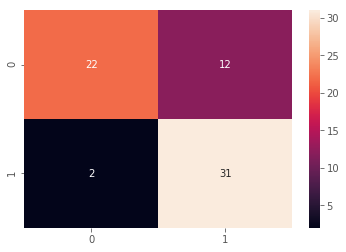

In [102]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
array = [[22, 12],
       [ 2, 31]]
df_cm = pd.DataFrame(array)
sn.heatmap(df_cm, annot=True)

#### Apply 5-fold Cross Validation on Random Forest

In [101]:
from sklearn.model_selection import cross_val_score
rf = RandomForestClassifier(n_estimators=100, max_depth=2,random_state=42)
rf_result = cross_val_score(rf, input_train, ncaa_selected_train['outcome'], cv=5, scoring='f1')
rf_result.mean()

0.7419831126052487

In [51]:
test_2019 = pd.read_csv('NCAA_Tourney_2019.csv')

In [52]:
test_2019_selected = pd.DataFrame()

In [53]:
test_2019.columns

Index(['game_id', 'team1_id', 'team2_id', 'season', 'team1_seed', 'team2_seed',
       'strongseed', 'weakseed', 'host_lat', 'host_long',
       'team1_pt_school_ncaa', 'team1_pt_overall_ncaa', 'team1_pt_school_s16',
       'team1_pt_overall_s16', 'team1_pt_school_ff', 'team1_pt_overall_ff',
       'team1_pt_career_school_wins', 'team1_pt_career_school_losses',
       'team1_pt_career_overall_losses', 'team1_pt_team_season_wins',
       'team1_pt_team_season_losses', 'team1_pt_coach_season_wins',
       'team1_pt_coach_season_losses', 'team1_pt_career_overall_wins',
       'team2_pt_school_ncaa', 'team2_pt_overall_ncaa', 'team2_pt_school_s16',
       'team2_pt_overall_s16', 'team2_pt_school_ff', 'team2_pt_overall_ff',
       'team2_pt_career_school_wins', 'team2_pt_career_school_losses',
       'team2_pt_career_overall_losses', 'team2_pt_team_season_wins',
       'team2_pt_team_season_losses', 'team2_pt_coach_season_wins',
       'team2_pt_coach_season_losses', 'team2_pt_career_overall

In [54]:
for i in list(test_2019.columns[1:]):
    test_2019[i].fillna(45.0, inplace=True)
    test_2019[i] = test_2019[i].astype(float).replace(0, 0.01)

'd_team_seed', 'q_team_seed', 'q_pt_overall_s16', 'q_ap_final',
       'd_ap_preseason', 'q_ap_preseason', 'd_coaches_before_final',
       'q_coaches_before_final', 'd_oppfg3pct', 'd_oe', 'd_adjoe', 'd_adjde'

In [55]:
test_2019_selected['d_team_seed'] = test_2019['team1_seed'] - \
    test_2019['team2_seed']
test_2019_selected['q_team_seed'] = test_2019['team1_seed'] / \
    test_2019['team2_seed']
test_2019_selected['q_ap_final'] = test_2019['team1_ap_final'] / \
    test_2019['team2_ap_final']
test_2019_selected['d_ap_preseason'] = test_2019['team1_ap_preseason'] - \
    test_2019['team2_ap_preseason']
test_2019_selected['q_ap_preseason'] = test_2019['team1_ap_preseason'] / \
    test_2019['team2_ap_preseason']
test_2019_selected['d_coaches_before_final'] = test_2019['team1_coaches_before_final'] - \
    test_2019['team2_coaches_before_final']
test_2019_selected['q_coaches_before_final'] = test_2019['team1_coaches_before_final'] / \
    test_2019['team2_coaches_before_final']
test_2019_selected['d_oppfg3pct'] = test_2019['team1_oppfg3pct'] - \
    test_2019['team2_oppfg3pct']
test_2019_selected['d_adjoe'] = test_2019['team1_adjoe'] - \
    test_2019['team2_adjoe']
test_2019_selected['d_oe'] = test_2019['team1_oe'] - test_2019['team2_oe']
test_2019_selected['d_adjde'] = test_2019['team1_adjde'] - \
    test_2019['team2_adjde']

In [56]:
test_2019_selected.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2278 entries, 0 to 2277
Data columns (total 11 columns):
d_team_seed               2278 non-null float64
q_team_seed               2278 non-null float64
q_ap_final                2278 non-null float64
d_ap_preseason            2278 non-null float64
q_ap_preseason            2278 non-null float64
d_coaches_before_final    2278 non-null float64
q_coaches_before_final    2278 non-null float64
d_oppfg3pct               2278 non-null float64
d_adjoe                   2278 non-null float64
d_oe                      2278 non-null float64
d_adjde                   2278 non-null float64
dtypes: float64(11)
memory usage: 195.8 KB


In [57]:
test_2019_selected['prediction'] = model.predict(
    test_2019_selected[test_2019_selected.columns[:]])

In [58]:
test_2019_selected.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2278 entries, 0 to 2277
Data columns (total 12 columns):
d_team_seed               2278 non-null float64
q_team_seed               2278 non-null float64
q_ap_final                2278 non-null float64
d_ap_preseason            2278 non-null float64
q_ap_preseason            2278 non-null float64
d_coaches_before_final    2278 non-null float64
q_coaches_before_final    2278 non-null float64
d_oppfg3pct               2278 non-null float64
d_adjoe                   2278 non-null float64
d_oe                      2278 non-null float64
d_adjde                   2278 non-null float64
prediction                2278 non-null int64
dtypes: float64(11), int64(1)
memory usage: 213.6 KB


In [59]:
test_2019_selected['probability'] = model.predict_proba(
    test_2019_selected[test_2019_selected.columns[:-1]])[:, 1]

In [60]:
test_2019_selected['game_id'] = test_2019['game_id']

In [61]:
test_2019_selected.to_csv('2019_prediction.csv')